# FocusGAN ECE 285 Final Project

Reference Paper: Visual Saliency SALGAN https://arxiv.org/pdf/1701.01081.pdf 

## imports

In [1]:
import zipfile
import requests
import os
import random
import matplotlib.pyplot as plt
import torchvision
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torch.optim as optim
vgg16 = torchvision.models.vgg16(pretrained=True)

notebook_path = os.getcwd()
print("Notebook path:", notebook_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 174MB/s]


Notebook path: /content


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
for dirpath, dirnames, filenames in os.walk('/content/gdrive/My Drive'):
    if 'testSet.zip' in filenames:
        print(f"Found in: {dirpath}")

Found in: /content/gdrive/My Drive
Found in: /content/gdrive/My Drive/Colab Notebooks


In [3]:
torch.cuda.is_available()

True

### Zip Extraction

In [ ]:
#file paths
test_path = '/content/gdrive/My Drive/Colab Notebooks/testSet.zip'  
train_path = '/content/gdrive/My Drive/Colab Notebooks/trainSet.zip'
extract_dir = '/content/gdrive/My Drive/Colab Notebooks'  

# Extraction
with zipfile.ZipFile(test_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
with zipfile.ZipFile(train_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("Dataset Extraction Successful")

Dataset Extraction Successful


## Visualize CAT2000 Training Dataset

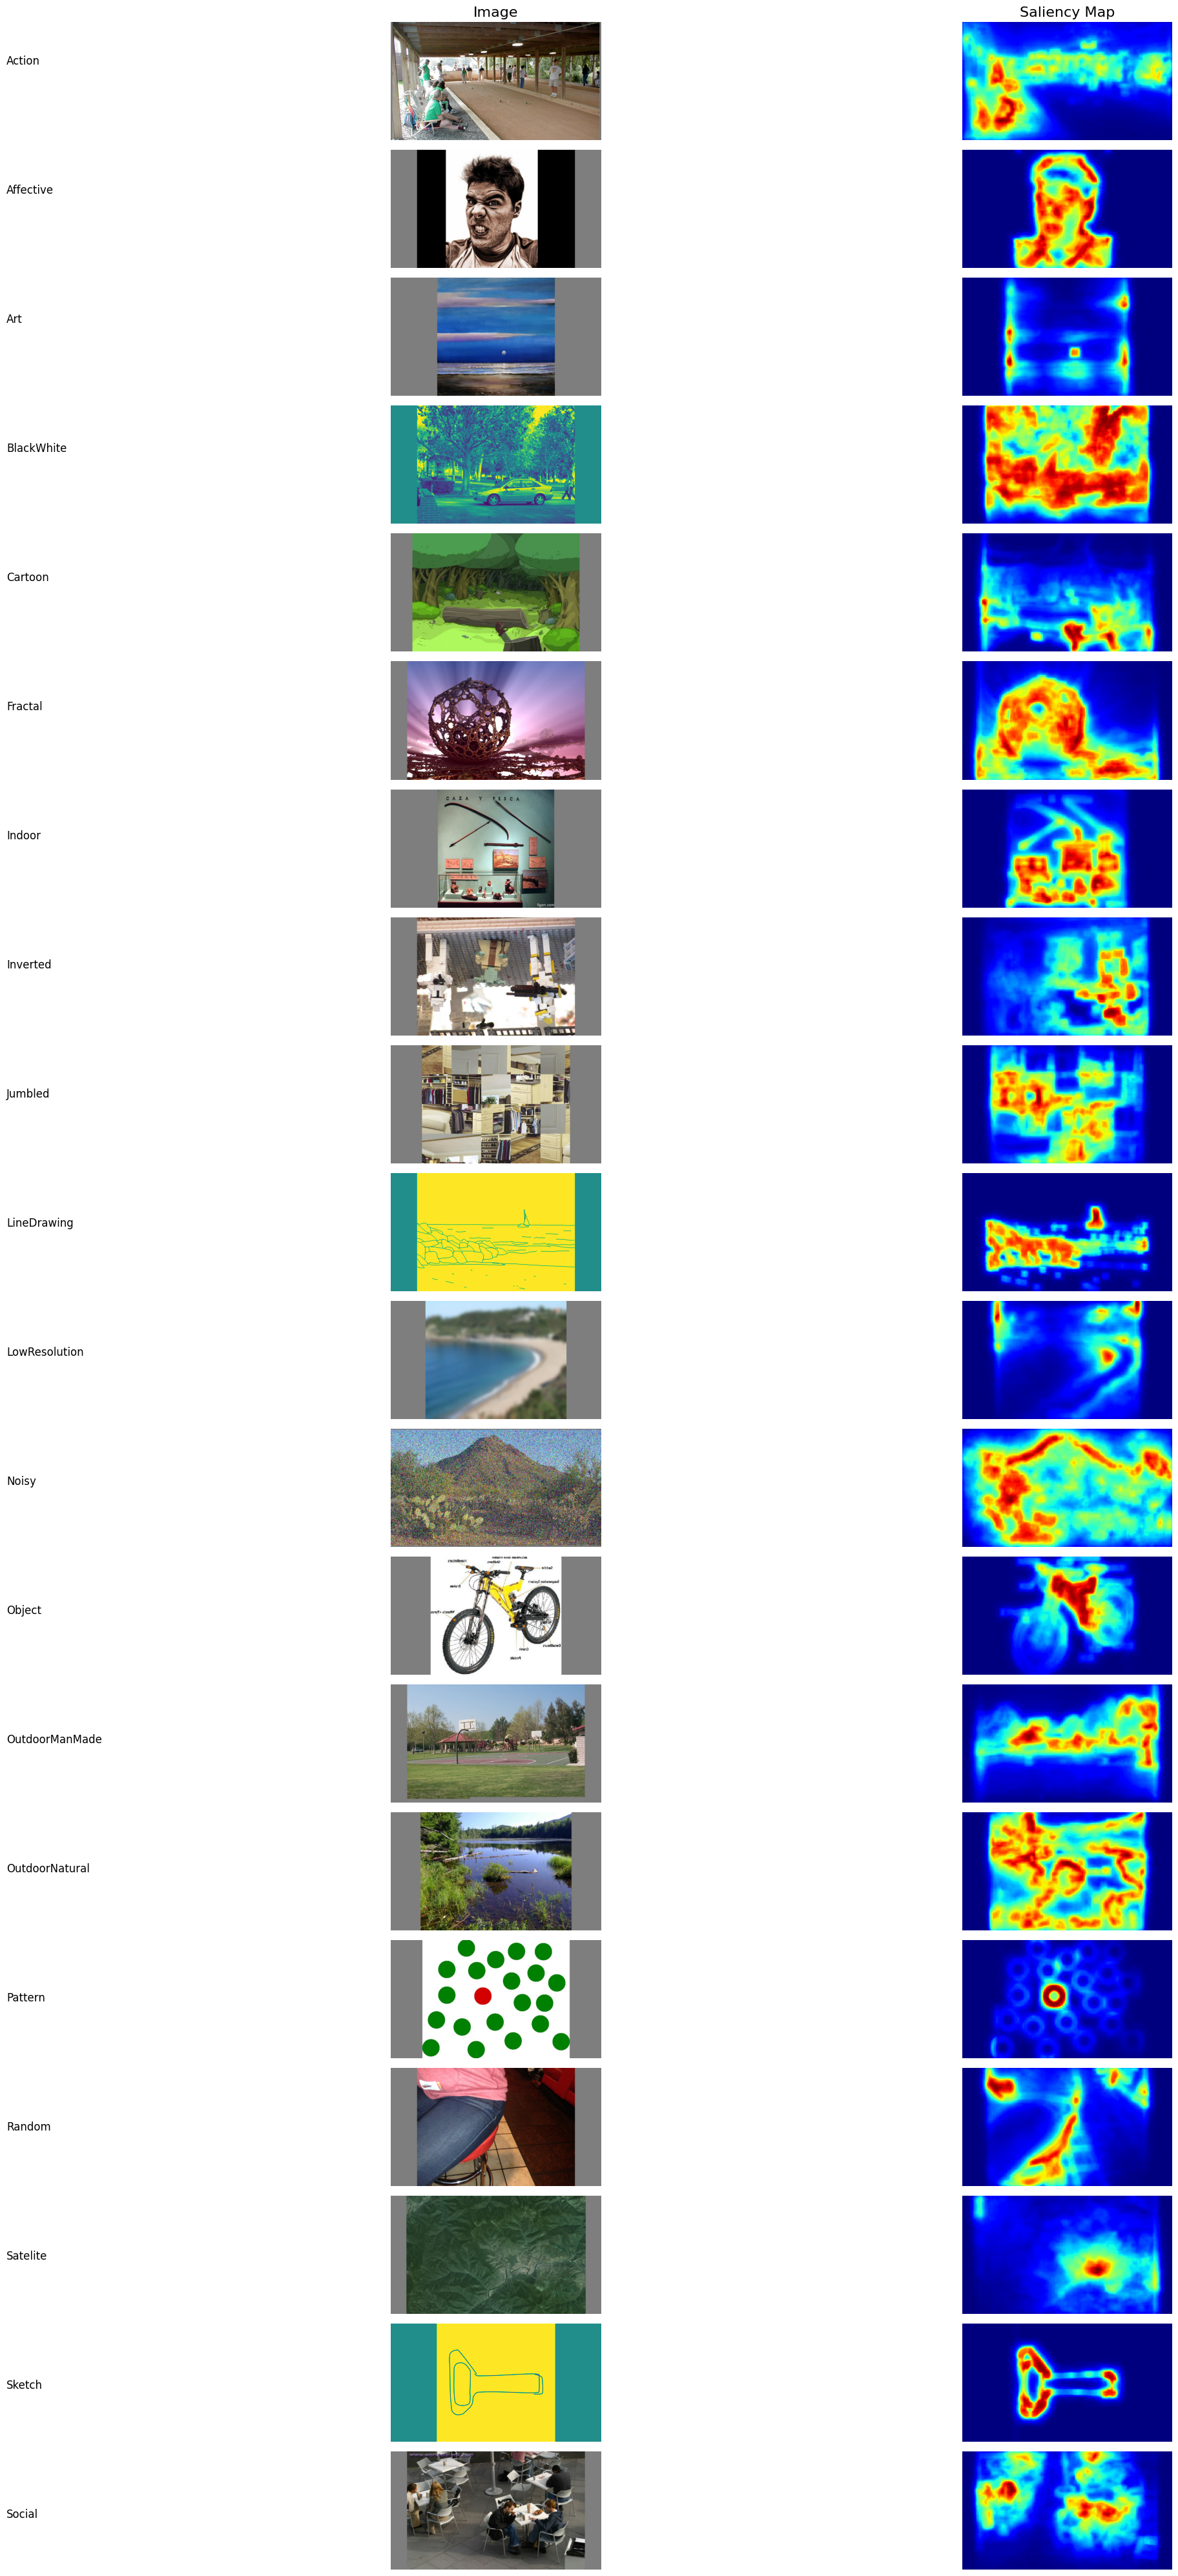

In [4]:
extract_dir = '/content/gdrive/My Drive/Colab Notebooks'
Categories = ["Action","Affective","Art","BlackWhite","Cartoon","Fractal","Indoor","Inverted","Jumbled","LineDrawing",
"LowResolution","Noisy","Object","OutdoorManMade","OutdoorNatural","Pattern","Random","Satelite","Sketch","Social"]



file_list = os.listdir(extract_dir + "/trainSet/Stimuli/Action")
random_image = random.choice(file_list)

rows = 20
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(24, 40))
x = 0
for i in Categories:
    file_list_stim = os.listdir(extract_dir + "/trainSet/Stimuli/" + i)
    random_image = random.choice(file_list_stim)
    image_path = os.path.join(extract_dir + "/trainSet/Stimuli/" + i, random_image)
    saliency_map = random_image.replace(".jpg","")+ "_SaliencyMap.jpg"
    saliency_map_path = os.path.join(extract_dir + "/trainSet/Stimuli/" + i + "/Output/", saliency_map ) 
    image = plt.imread(image_path)
    saliency_map = plt.imread(saliency_map_path)
    
    #display random image from trainset category
    axes[x, 0].imshow(image)
    axes[x, 0].axis('off')
    
    #display its respective saliency map
    axes[x, 1].imshow(saliency_map, cmap='jet')  
    axes[x, 1].axis('off')
    
    #Column title 
    if x == 0:
        axes[x, 0].set_title('Image', fontsize=16)
        axes[x, 1].set_title('Saliency Map', fontsize=16)

    # Row labels
    fig.text(0, (rows-x-0.5)/rows, i, ha='left', va='center', fontsize=12)
    
    x += 1
    
    
plt.tight_layout()
plt.show()
    


## Dataloader and Device Setup

In [ ]:

#Function to create data_list which is list of tuples (image_path,ground_truth_path) 
def get_data_list(root_directory):
    data_list = []
    for category in Categories:
        category_dir = os.path.join(root_directory,category)
        ground_truth_dir = os.path.join(category_dir,"Output")
        
        for image in os.listdir(category_dir):
            if image.endswith("jpg"):
                image_path = os.path.join(category_dir,image)
                ground_truth_path = os.path.join(ground_truth_dir,image.replace(".jpg","")+ "_SaliencyMap.jpg")
            
                data_list.append((image_path,ground_truth_path))
        
    return data_list

#Transformations
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

map_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor()
])

#data_list from training data
train_dir = '/content/gdrive/My Drive/Colab Notebooks/trainSet/Stimuli/'
data_list = get_data_list(train_dir)

#split data_list into training and validation datasets
train_data,val_data = train_test_split(data_list, test_size = 0.2, random_state = 28) #random seed same for debugging purposes

#test set 
test_dir = '/content/gdrive/My Drive/Colab Notebooks/testSet/Stimuli/'
test_data = get_data_list(test_dir)


#2000 test, 2000 training, and 400 validation seems unreasonable 
#get full data list 
full_data_list = data_list + test_data 


#split into 80, 20, 20
train_data, temp = train_test_split(full_data_list, test_size = 0.2, random_state = 28) #random seed same for debugging purposes
test_data, val_data = train_test_split(temp, test_size = 0.5, random_state = 28) #random seed same for debugging purposes


#Input tranformed images and saliency maps instead of their paths
train_data = [(image_transform(Image.open(image_path).convert('RGB')), map_transform(Image.open(ground_truth_path).convert('L'))) for image_path, ground_truth_path in train_data]
val_data = [(image_transform(Image.open(image_path).convert('RGB')), map_transform(Image.open(ground_truth_path).convert('L'))) for image_path, ground_truth_path in val_data]
test_data = [(image_transform(Image.open(image_path).convert('RGB')), map_transform(Image.open(ground_truth_path).convert('L'))) for image_path, ground_truth_path in test_data]


print("Training Set Size:", len(train_data))
print("Validation Set Size:", len(val_data))
print("Test Set Size:", len(test_data))

train_loader = torch.utils.data.DataLoader(     #might need to change batch_size depending on training
    train_data, batch_size=32, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=32, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=32, shuffle=False
)



USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)
    
    

In [ ]:
torch.cuda.is_available()

True

## Generator

In [ ]:


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #Defining U-Net Generator Layers
        self.conv1_1 = nn.Conv2d(3, 64, 3, stride = 1, padding=1) #kernel size is 1 in paper not identical to vgg16
        self.conv1_2 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)
        self.pool1 =  nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = False) #ceil mode
        self.conv2_1 = nn.Conv2d(64, 128, 3, stride = 1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, 3, stride = 1, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = False)
        self.conv3_1 = nn.Conv2d(128, 256, 3, stride = 1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, stride = 1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, 3, stride = 1, padding=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = False)
        self.conv4_1 = nn.Conv2d(256, 512, 3, stride = 1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = False)
        self.conv5_1 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv6_1 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv6_2 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv6_3 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.upsample6 = nn.ConvTranspose2d(512, 512, 2, stride = 2, bias = False) #i think bias should be false
        self.conv7_1 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv7_2 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv7_3 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.upsample7 = nn.ConvTranspose2d(512, 512, 2, stride = 2, bias = False)
        self.conv8_1 = nn.Conv2d(512, 256, 3, stride = 1, padding=1)
        self.conv8_2 = nn.Conv2d(256, 256, 3, stride = 1, padding=1)
        self.conv8_3 = nn.Conv2d(256, 256, 3, stride = 1, padding=1)
        self.upsample8 = nn.ConvTranspose2d(256, 256, 2, stride = 2, bias = False)
        self.conv9_1 = nn.Conv2d(256, 128, 3, stride = 1, padding=1)
        self.conv9_2 = nn.Conv2d(128, 128, 3, stride = 1, padding=1)
        self.upsample9 = nn.ConvTranspose2d(128, 128, 2, stride = 2, bias = False)
        self.conv10_1 = nn.Conv2d(128, 64, 3, stride = 1, padding=1)
        self.conv10_2 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)
        self.output = nn.Conv2d(64, 1, 1, stride = 1, padding=0)
        #activation layers
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

        
        #initialize encoder layer weights using VGG16 pretrained weights
        self.copy_params_from_vgg16(vgg16)
        #initialize decoder layer weights randomly using Xavier Initialization
        self._initialize_weights()

        
    def _initialize_weights(self):
        #only randomly initialize weights of decoder layers we use Xavier Initialization
        decoder_layers = [self.conv6_1, self.conv6_2, self.conv6_3, self.upsample6,
                         self.conv7_1, self.conv7_2, self.conv7_3, self.upsample7,
                         self.conv8_1, self.conv8_2, self.conv8_3, self.upsample8,
                         self.conv9_1, self.conv9_2, self.upsample9,
                         self.conv10_1, self.conv10_2, self.output]
        for layer in decoder_layers:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                layer.bias.data.zero_()


    def forward(self, x):
        
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.pool1(x)
        
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))    
        x = self.pool2(x)
        
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.relu(self.conv3_3(x))    
        x = self.pool3(x)
        
        x = self.relu(self.conv4_1(x))
        x = self.relu(self.conv4_2(x))
        x = self.relu(self.conv4_3(x))   
        x = self.pool4(x)
        
        x = self.relu(self.conv5_1(x))
        x = self.relu(self.conv5_2(x))
        x = self.relu(self.conv5_3(x))
        
        x = self.relu(self.conv6_1(x))
        x = self.relu(self.conv6_2(x))
        x = self.relu(self.conv6_3(x))
        x = self.upsample6(x)
        
        x = self.relu(self.conv7_1(x))
        x = self.relu(self.conv7_2(x))
        x = self.relu(self.conv7_3(x))
        x = self.upsample7(x)
        
        x = self.relu(self.conv8_1(x))
        x = self.relu(self.conv8_2(x))
        x = self.relu(self.conv8_3(x))
        x = self.upsample8(x)
        
        x = self.relu(self.conv9_1(x))
        x = self.relu(self.conv9_2(x))
        x = self.upsample9(x)
        
        x = self.relu(self.conv10_1(x))
        x = self.relu(self.conv10_2(x))
        x = self.sigmoid(self.output(x))  

        return x

    
    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1,
            self.conv1_2,
            self.pool1,
            self.conv2_1,
            self.conv2_2,
            self.pool2,
            self.conv3_1,
            self.conv3_2,
            self.conv3_3,
            self.pool3,
            self.conv4_1,
            self.conv4_2,
            self.conv4_3,
            self.pool4,
            self.conv5_1,
            self.conv5_2,
            self.conv5_3,
        ]
        
        
        vgg_blocks = [l for l in vgg16.features.children() if isinstance(l, nn.Conv2d)]
        self_blocks = [self.conv1_1, self.conv1_2, self.conv2_1, self.conv2_2, self.conv3_1, self.conv3_2, self.conv3_3, self.conv4_1, self.conv4_2, self.conv4_3, self.conv5_1, self.conv5_2, self.conv5_3]

        for l1, l2 in zip(vgg_blocks, self_blocks):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        
        #fix layer weights before last two convolutional layers of VGG16
        fixed_weight_layers = [self.conv1_1, self.conv1_2,
            self.conv2_1, self.conv2_2,
            self.conv3_1, self.conv3_2, self.conv3_3]
        for layer in fixed_weight_layers:
            for param in layer.parameters():
                param.requires_grad = False
            

print(Generator())

Generator(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4

## U-Net Generator 

In [ ]:


class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        #Defining U-Net Generator Layers
        self.conv1_1 = nn.Conv2d(3, 64, 3, stride = 1, padding=1) #kernel size is 1 in paper not identical to vgg16
        self.conv1_2 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)
        self.pool1 =  nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = False) #ceil mode
        self.conv2_1 = nn.Conv2d(64, 128, 3, stride = 1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, 3, stride = 1, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = False)
        self.conv3_1 = nn.Conv2d(128, 256, 3, stride = 1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, stride = 1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, 3, stride = 1, padding=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = False)
        self.conv4_1 = nn.Conv2d(256, 512, 3, stride = 1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = False)
        self.conv5_1 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv6_1 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv6_2 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv6_3 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.upsample6 = nn.ConvTranspose2d(512, 512, 2, stride = 2, bias = False) #i think bias should be false
        self.conv7_1 = nn.Conv2d(1024, 512, 3, stride = 1, padding=1)
        self.conv7_2 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv7_3 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.upsample7 = nn.ConvTranspose2d(512, 256, 2, stride = 2, bias = False)
        self.conv8_1 = nn.Conv2d(512, 256, 3, stride = 1, padding=1)
        self.conv8_2 = nn.Conv2d(256, 256, 3, stride = 1, padding=1)
        self.conv8_3 = nn.Conv2d(256, 256, 3, stride = 1, padding=1)
        self.upsample8 = nn.ConvTranspose2d(256, 128, 2, stride = 2, bias = False)
        self.conv9_1 = nn.Conv2d(256, 128, 3, stride = 1, padding=1)
        self.conv9_2 = nn.Conv2d(128, 128, 3, stride = 1, padding=1)
        self.upsample9 = nn.ConvTranspose2d(128, 64, 2, stride = 2, bias = False)
        self.conv10_1 = nn.Conv2d(128, 64, 3, stride = 1, padding=1)
        self.conv10_2 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)
        self.output = nn.Conv2d(64, 1, 1, stride = 1, padding=0)
        #activation layers
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

        
        #initialize encoder layer weights using VGG16 pretrained weights
        self.copy_params_from_vgg16(vgg16)
        #initialize decoder layer weights randomly using Xavier Initialization
        self._initialize_weights()

        
    def _initialize_weights(self):
        #only randomly initialize weights of decoder layers we use Xavier Initialization
        decoder_layers = [self.conv6_1, self.conv6_2, self.conv6_3, self.upsample6,
                         self.conv7_1, self.conv7_2, self.conv7_3, self.upsample7,
                         self.conv8_1, self.conv8_2, self.conv8_3, self.upsample8,
                         self.conv9_1, self.conv9_2, self.upsample9,
                         self.conv10_1, self.conv10_2, self.output]
        for layer in decoder_layers:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                layer.bias.data.zero_()


    def forward(self, x):
        
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        #Save Layer 1 Output
#         print("Layer 1 size:")
#         print(x.size())
        conv1_fmap = x 
        x = self.pool1(x)
        
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        #Save Layer 2 Output
#         print("Layer 2 size:")
#         print(x.shape)
        conv2_fmap = x      
        x = self.pool2(x)
        
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.relu(self.conv3_3(x))
        #Save Layer 3 Output
#         print("Layer 3 size:")
#         print(x.shape)
        conv3_fmap = x      
        x = self.pool3(x)
        
        x = self.relu(self.conv4_1(x))
        x = self.relu(self.conv4_2(x))
        x = self.relu(self.conv4_3(x))
        #Save Layer 4 Output
#         print("Layer 4 size:")
#         print(x.shape)
        conv4_fmap = x    
        x = self.pool4(x)
        
        x = self.relu(self.conv5_1(x))
        x = self.relu(self.conv5_2(x))
        x = self.relu(self.conv5_3(x))
        
        x = self.relu(self.conv6_1(x))
        x = self.relu(self.conv6_2(x))
        x = self.relu(self.conv6_3(x))
        x = self.upsample6(x)
        
        #Conactenate upsampled fmap with conv4_fmap
#         print("Layer 4 compat size:")
#         print(x.shape)
        x = torch.cat([conv4_fmap,x], dim = 1)
        x = self.relu(self.conv7_1(x))
        x = self.relu(self.conv7_2(x))
        x = self.relu(self.conv7_3(x))
        x = self.upsample7(x)
        
        
        #Conactenate upsampled fmap with conv3_fmap
#         print("Layer 3 compat size:")
#         print(x.shape)
        x = torch.cat([conv3_fmap,x], dim = 1)
        x = self.relu(self.conv8_1(x))
        x = self.relu(self.conv8_2(x))
        x = self.relu(self.conv8_3(x))
        x = self.upsample8(x)
        
        #Conactenate upsampled fmap with conv2_fmap
#         print("Layer 2 compat size:")
#         print(x.shape)
        x = torch.cat([conv2_fmap,x], dim = 1)
        x = self.relu(self.conv9_1(x))
        x = self.relu(self.conv9_2(x))
        x = self.upsample9(x)
        
        #Conactenate upsampled fmap with conv1_fmap
#         print("Layer 1 compat size:")
#         print(x.shape)
        x = torch.cat([conv1_fmap,x], dim = 1)
        x = self.relu(self.conv10_1(x))
        x = self.relu(self.conv10_2(x))
        x = self.sigmoid(self.output(x))  

        return x

    
    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1,
            self.conv1_2,
            self.pool1,
            self.conv2_1,
            self.conv2_2,
            self.pool2,
            self.conv3_1,
            self.conv3_2,
            self.conv3_3,
            self.pool3,
            self.conv4_1,
            self.conv4_2,
            self.conv4_3,
            self.pool4,
            self.conv5_1,
            self.conv5_2,
            self.conv5_3,
        ]
        
        
        vgg_blocks = [l for l in vgg16.features.children() if isinstance(l, nn.Conv2d)]
        self_blocks = [self.conv1_1, self.conv1_2, self.conv2_1, self.conv2_2, self.conv3_1, self.conv3_2, self.conv3_3, self.conv4_1, self.conv4_2, self.conv4_3, self.conv5_1, self.conv5_2, self.conv5_3]

        for l1, l2 in zip(vgg_blocks, self_blocks):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        
        #fix layer weights before last two convolutional layers of VGG16
        fixed_weight_layers = [self.conv1_1, self.conv1_2,
            self.conv2_1, self.conv2_2,
            self.conv3_1, self.conv3_2, self.conv3_3]
        for layer in fixed_weight_layers:
            for param in layer.parameters():
                param.requires_grad = False
            

print(UNetGenerator())

UNetGenerator(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c

## Discriminator 

In [ ]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #Defining Discriminator Layers
        self.conv1_1 = nn.Conv2d(4, 3, 1, stride = 1, padding=1)
        self.conv1_2 = nn.Conv2d(3, 32, 3, stride = 1, padding=1)
        self.pool1 =  nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = False)
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride = 1, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)
        self.pool2 =  nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = False)
        self.conv3_1 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)
        self.pool3 =  nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = False)
        self.fc4 = nn.Linear(64*32*32,100) #kinda hard coding should fix
        self.fc5 = nn.Linear(100,2)
        self.fc6 = nn.Linear(2,1)

        #activation layers
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        
        #initialize decoder layer weights randomly using Xavier Initialization
        self._initialize_discriminator_weights()

        
    def _initialize_discriminator_weights(self):
        #only randomly initialize weights of decoder layers we use Xavier Initialization
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    layer.bias.data.zero_()



    def forward(self, x):
        
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.pool1(x)
        
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))     
        x = self.pool2(x)
        
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))  
        x = self.pool3(x)
        #print(x.shape)
        x = flatten(x)
        
        
        x = self.tanh(self.fc4(x))
        
        x = self.tanh(self.fc5(x))
        
        x = self.sigmoid(self.fc6(x))

        return x
    
print(Discriminator())

Discriminator(
  (conv1_1): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc4): Linear(in_features=65536, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=2, bias=True)
  (fc6): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
)


## U-Net GAN 

In [ ]:
#vgg16 = torchvision.models.vgg16(pretrained=True)
UNetGen = UNetGenerator().to(device)
Discriminator = Discriminator().to(device)

## Trainer

In [ ]:

def train(Generator,Discriminator,dataloader,epochs = 20):
    
    
    #Pretrain Generator() for 15 epochs using BCE
    pretrain_epochs = 15
    for epoch in range(pretrain_epochs):
        pretrain_losses = []
        print(f"Pretrain Epoch {epoch+1}/{pretrain_epochs}")
        for batch, (images, true_saliency_maps) in enumerate(dataloader):
            images = images.to(device)
            true_saliency_maps = true_saliency_maps.to(device)
#             print(f"Images Shape: {images.shape}")
#             print(f"True Saliency Maps Shape: {true_saliency_maps.shape}")
            
            #zero generator gradients
            optimizerG.zero_grad()
            
            #get generated saliency map
            generated_smap = Generator(images)
            
            #BCE Loss
            BCE_loss = criterion(generated_smap,true_saliency_maps)
            pretrain_losses.append(BCE_loss.item())
            
            #backward pass and optim
            BCE_loss.backward()
            optimizerG.step()
            
        avg_pretrain_loss = sum(pretrain_losses) / len(pretrain_losses)
        print(f"Pretrain Epoch {epoch+1}/{pretrain_epochs}, Average Loss: {avg_pretrain_loss:.4f}")
            
            
    #Adversarial training of Generator and Discriminator 
    for epoch in range(epochs):
        adversarial_losses = []
        generator_losses = []
        for batch, (images, true_saliency_maps) in enumerate(dataloader):
            images = images.to(device)
            true_saliency_maps = true_saliency_maps.to(device)
            
            #zero gradients of generator and discriminator
            optimizerG.zero_grad()
            optimizerD.zero_grad()
            
            #get generated saliency map
            generated_smap = Generator(images)
            
            #concatenate rgb image with saliency map(RGBS)
            real_rgbs = torch.cat((images, true_saliency_maps), dim = 1)
            fake_rgbs = torch.cat((images, generated_smap.detach()), dim = 1) #.detach() so only disc weights are updated
            
            #train Discriminator
            real_outputs = Discriminator(real_rgbs)
            fake_outputs = Discriminator(fake_rgbs)
            
            #real label is 1, fake label is 0
            real_labels = torch.ones_like(real_outputs)
            fake_labels = torch.zeros_like(fake_outputs)
            
            #calculate discriminator loss
            real_d_loss = criterion(real_outputs, real_labels)
            fake_d_loss = criterion(fake_outputs, fake_labels)
            d_loss = real_d_loss + fake_d_loss
            adversarial_losses.append(d_loss.item())
            
            #backward pass and optim for discriminator 
            d_loss.backward()
            optimizerD.step()
            
            #pass generated data to discriminator after training it
            fake_outputs = Discriminator(fake_rgbs)
            
            #optimizing generator 
            g_loss = criterion(fake_outputs, real_labels)
            generator_losses.append(g_loss.item())
            
            g_loss.backward()
            optimizerG.step()
            
            
        avg_adversarial_loss = sum(adversarial_losses) / len(adversarial_losses)
        print(f"Adversarial Epoch {epoch+1}/{epochs}, Average Loss: {avg_adversarial_loss:.4f}")

    print("Training finished!")


In [ ]:
epochs = 5
lr = 3e-4
alpha = 1e-4
criterion = nn.BCELoss()
dataloader = train_loader
optimizerG = optim.Adagrad(UNetGen.parameters(), lr = lr, weight_decay = alpha)
optimizerD = optim.Adagrad(Discriminator.parameters(), lr = lr, weight_decay = alpha)
for epoch in range(epochs):
        adversarial_losses = []
        for batch, (images, true_saliency_maps) in enumerate(dataloader):
            images = images.to(device)
            true_saliency_maps = true_saliency_maps.to(device)
            
            #zero gradients of generator and discriminator
            optimizerG.zero_grad()
            optimizerD.zero_grad()
            
            #get generated saliency map
            generated_smap = UNetGen(images)
            print("Generated saliency map shape:", generated_smap.shape)
            
            #concatenate rgb image with saliency map(RGBS)
            real_rgbs = torch.cat((images, true_saliency_maps), dim = 1)
            fake_rgbs = torch.cat((images, generated_smap.detach()), dim = 1) #.detach() so only disc weights are updated
            print("Real RGBS shape:", real_rgbs.shape)
            print("Fake RGBS shape:", fake_rgbs.shape)

            #train Discriminator
            real_outputs = Discriminator(real_rgbs)
            fake_outputs = Discriminator(fake_rgbs)
            print("Real outputs shape:", real_outputs.shape)
            print("Fake outputs shape:", fake_outputs.shape)
            
            #real label is 1, fake label is 0
            #real_labels = torch.ones(real_outputs.size(),1)
            real_labels = torch.ones_like(real_outputs)
            fake_labels = torch.zeros_like(fake_outputs)
            print("Real labels shape:", real_labels.shape)
            print("Fake labels shape:", fake_labels.shape)
            
            #calculate discriminator loss
            real_d_loss = criterion(real_outputs, real_labels)
            fake_d_loss = criterion(fake_outputs, fake_labels)
            d_loss = real_d_loss + fake_d_loss
            adversarial_losses.append(d_loss.item())
            
            #backward pass and optim for discriminator 
            d_loss.backward()
            optimizerD.step()
            
            #pass generated data to discriminator after training it
            fake_outputs = Discriminator(fake_rgbs)
            
            #optimizing generator 
            g_loss = criterion(fake_outputs, real_labels)
            
            g_loss.backward()
            optimizerG.step()
            
            
        avg_adversarial_loss = sum(adversarial_losses) / len(adversarial_losses)
        print(f"Adversarial Epoch {epoch+1}/{epochs}, Average Loss: {avg_adversarial_loss:.4f}")



Generated saliency map shape: torch.Size([32, 1, 256, 256])
Real RGBS shape: torch.Size([32, 4, 256, 256])
Fake RGBS shape: torch.Size([32, 4, 256, 256])
Real outputs shape: torch.Size([32, 1])
Fake outputs shape: torch.Size([32, 1])
Real labels shape: torch.Size([32, 1])
Fake labels shape: torch.Size([32, 1])
Generated saliency map shape: torch.Size([32, 1, 256, 256])
Real RGBS shape: torch.Size([32, 4, 256, 256])
Fake RGBS shape: torch.Size([32, 4, 256, 256])
Real outputs shape: torch.Size([32, 1])
Fake outputs shape: torch.Size([32, 1])
Real labels shape: torch.Size([32, 1])
Fake labels shape: torch.Size([32, 1])
Generated saliency map shape: torch.Size([32, 1, 256, 256])
Real RGBS shape: torch.Size([32, 4, 256, 256])
Fake RGBS shape: torch.Size([32, 4, 256, 256])
Real outputs shape: torch.Size([32, 1])
Fake outputs shape: torch.Size([32, 1])
Real labels shape: torch.Size([32, 1])
Fake labels shape: torch.Size([32, 1])
Generated saliency map shape: torch.Size([32, 1, 256, 256])
Real

KeyboardInterrupt: ignored

## Training UNetGAN

In [ ]:
lr = 3e-4
alpha = 1e-4



criterion = nn.BCELoss()
optimizerG = optim.Adagrad(UNetGen.parameters(), lr = lr, weight_decay = alpha)
optimizerD = optim.Adagrad(Discriminator.parameters(), lr = lr, weight_decay = alpha)
model = train(UNetGen,Discriminator,train_loader,epochs = 20)

Pretrain Epoch 1/15
Pretrain Epoch 1/15, Average Loss: 0.4663
Pretrain Epoch 2/15
Pretrain Epoch 2/15, Average Loss: 0.4032
Pretrain Epoch 3/15
Pretrain Epoch 3/15, Average Loss: 0.3959
Pretrain Epoch 4/15
Pretrain Epoch 4/15, Average Loss: 0.3920
Pretrain Epoch 5/15
Pretrain Epoch 5/15, Average Loss: 0.3891
Pretrain Epoch 6/15
Pretrain Epoch 6/15, Average Loss: 0.3877
Pretrain Epoch 7/15
Pretrain Epoch 7/15, Average Loss: 0.3865
Pretrain Epoch 8/15
Pretrain Epoch 8/15, Average Loss: 0.3853
Pretrain Epoch 9/15
Pretrain Epoch 9/15, Average Loss: 0.3841
Pretrain Epoch 10/15
Pretrain Epoch 10/15, Average Loss: 0.3836
Pretrain Epoch 11/15
Pretrain Epoch 11/15, Average Loss: 0.3830
Pretrain Epoch 12/15
Pretrain Epoch 12/15, Average Loss: 0.3821
Pretrain Epoch 13/15
Pretrain Epoch 13/15, Average Loss: 0.3816
Pretrain Epoch 14/15
Pretrain Epoch 14/15, Average Loss: 0.3805
Pretrain Epoch 15/15
Pretrain Epoch 15/15, Average Loss: 0.3802
Adversarial Epoch 1/20, Average Loss: 1.3623
Adversarial E

## Results